# X-Light: Cross-City Traffic Signal Control Implementation
## Based on IJCAI 2024 Paper

This notebook implements the X-Light method from:
**"X-Light: Cross-City Traffic Signal Control Using Transformer on Transformer as Meta Multi-Agent Reinforcement Learner"**

### Key Requirements:
1. SUMO traffic simulator (install via: `brew install sumo` on Mac)
2. Python packages: torch, numpy, sumolib, traci
3. Scenarios: Grid 4x4, Avenue 4x4, Grid 5x5, Cologne8, Ingolstadt21

### Paper Specifications:
- **Simulator**: SUMO with TraCI
- **Episode Duration**: 3600 seconds  
- **Time Step (Δt)**: 15 seconds
- **Action**: 8 pre-defined phases
- **State**: queue length, current phase, occupancy, flow, stopping cars (5 features)
- **Reward**: weighted sum of queue length, wait time, delay, pressure
- **History Length (K)**: 10 timesteps
- **Neighbors (n)**: 4 nearest intersections
- **Lower Transformer**: 3 layers, d=64
- **Upper Transformer**: 3 layers, d'=128  
- **Algorithm**: PPO with multi-scenario co-training

In [1]:
%%bash
# Install SUMO (this takes ~2 minutes)
echo "Installing SUMO..."

# Add SUMO repository
sudo add-apt-repository ppa:sumo/stable -y
sudo apt-get update

# Install SUMO packages
sudo apt-get install -y sumo sumo-tools sumo-doc

# Set SUMO_HOME environment variable
echo 'export SUMO_HOME="/usr/share/sumo"' >> ~/.bashrc
echo 'export PATH="$SUMO_HOME/tools:$PATH"' >> ~/.bashrc

echo "✓ SUMO installed successfully!"
sumo --version

Installing SUMO...
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,204 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,623 kB]
Get:13 https://ppa.launchpadcontent

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 25.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [2]:
!pip install traci

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.5/278.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 22.4 MB/s eta 0:00:00


In [3]:
# Set SUMO_HOME for this session
import os
import sys

os.environ['SUMO_HOME'] = '/usr/share/sumo'
sys.path.append('/usr/share/sumo/tools')

print("✓ SUMO_HOME set:", os.environ['SUMO_HOME'])

✓ SUMO_HOME set: /usr/share/sumo


In [4]:
# Install SUMO (only needed first time)
import sys
import subprocess

def install_sumo():
    """Install SUMO traffic simulator"""
    if sys.platform == 'linux':
        print("Installing SUMO on Linux...")
        commands = [
            "apt-get update",
            "add-apt-repository ppa:sumo/stable -y",
            "apt-get update",
            "apt-get install sumo sumo-tools sumo-doc -y"
        ]
        for cmd in commands:
            subprocess.run(cmd, shell=True, check=False)
    else:
        print("⚠️  Please install SUMO manually:")
        print("   macOS: brew install sumo")
        print("   Windows: https://sumo.dlr.de/docs/Downloads.php")

# Uncomment to install SUMO
# install_sumo()

print("✓ Installation ready!")

✓ Installation ready!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
from collections import deque
import random
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
import os
import sys

import traci
import sumolib

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup (Apple Silicon GPU support)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("⚠️  Using CPU")

print(f"Device: {device}")

✓ Using NVIDIA GPU
Device: cuda


In [6]:
import os
import shutil
import glob

# Define paths
grid4x4_path = '/content/scenarios/grid4x4'
routes_zip = os.path.join(grid4x4_path, 'grid4x4.zip') # Assumes you uploaded the zip here
routes_folder = os.path.join(grid4x4_path, 'routes')

# Create folder for routes
os.makedirs(routes_folder, exist_ok=True)

# Unzip if not already done
if os.path.exists(routes_zip):
    print(f"📂 Found zip file at {routes_zip}. Unzipping...")
    shutil.unpack_archive(routes_zip, routes_folder)
    print(f"✅ Unzipped to {routes_folder}")

    # Check count
    route_files = glob.glob(os.path.join(routes_folder, "*.rou.xml"))
    print(f"📊 Found {len(route_files)} route files available for training.")
else:
    print(f"⚠️ Zip file not found at {routes_zip}. Please check the path.")

📂 Found zip file at /content/scenarios/grid4x4/grid4x4.zip. Unzipping...
✅ Unzipped to /content/scenarios/grid4x4/routes
📊 Found 1400 route files available for training.


## 1. Model Architecture

### Lower Transformer (Section 3.2 in paper)
- Aggregates observations (o), actions (a), and rewards (r) from target and neighbors
- 3 multi-head self-attention layers
- d_model = 64 dimensions
- Separate embeddings for o, a, r
- Decision token prepended

### Upper Transformer (Section 3.3 in paper)  
- Learns scenario-agnostic decision policies
- 3 multi-head self-attention layers
- d' = 128 dimensions
- Takes last K=10 timesteps from Lower Transformer
- Dynamic predictor for environment dynamics

In [7]:
class LowerTransformer(nn.Module):
    """
    Lower Transformer as described in X-Light paper Section 3.2
    Aggregates (o, a, r) from target intersection and n neighbors
    """
    def __init__(self, obs_dim=25, action_dim=8, d_model=64, nhead=4, num_layers=3, n_neighbors=4):
        super().__init__()
        self.d_model = d_model
        self.n_neighbors = n_neighbors

        # Separate embedding projections for o, a, r (Equation 2)
        self.E_o = nn.Linear(obs_dim, d_model)  # Observation embedding
        self.E_a = nn.Linear(action_dim, d_model)  # Action embedding
        self.E_r = nn.Linear(1, d_model)  # Reward embedding

        # Learnable [decision] token (Section 3.2)
        self.q_decision = nn.Parameter(torch.randn(1, 1, d_model))

        # Position embedding (Equation 3)
        # Total tokens: [decision] + (target + n neighbors) * 3 (o,a,r each)
        max_seq_len = 1 + 3 * (1 + n_neighbors)  # 1 + 3*5 = 16 tokens
        self.E_pos_lower = nn.Parameter(torch.randn(1, max_seq_len, d_model))

        # Transformer encoder with 3 layers (as per paper)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, obs, actions, rewards, mask=None):
        """
        Args:
            obs: [batch, 1+n_neighbors, obs_dim] - observations from target + neighbors
            actions: [batch, 1+n_neighbors, action_dim] - previous actions (one-hot)
            rewards: [batch, 1+n_neighbors, 1] - previous rewards
            mask: Optional attention mask
        Returns:
            c_t: [batch, d_model] - intersection embedding from decision token
        """
        batch_size = obs.shape[0]

        # Apply separate embeddings (Equation 2)
        obs_emb = self.E_o(obs)  # [batch, 1+n, d]
        act_emb = self.E_a(actions)  # [batch, 1+n, d]
        rew_emb = self.E_r(rewards)  # [batch, 1+n, d]

        # Interleave o, a, r for each intersection (target + neighbors)
        # Create sequence: [o_target, a_target, r_target, o_n1, a_n1, r_n1, ...]
        seq_list = []
        for i in range(1 + self.n_neighbors):
            seq_list.extend([obs_emb[:, i:i+1, :], act_emb[:, i:i+1, :], rew_emb[:, i:i+1, :]])

        mdp_seq = torch.cat(seq_list, dim=1)  # [batch, 3*(1+n), d]

        # Prepend decision token (Equation 3)
        decision_token = self.q_decision.expand(batch_size, -1, -1)
        sequence = torch.cat([decision_token, mdp_seq], dim=1)

        # Add positional embedding
        sequence = sequence + self.E_pos_lower[:, :sequence.shape[1], :]

        # Apply transformer (Equation 4)
        output = self.transformer(sequence, mask=mask)

        # Return decision token output as intersection embedding c_t
        c_t = output[:, 0, :]
        return c_t

print("✓ Lower Transformer defined")

✓ Lower Transformer defined


In [8]:
class UpperTransformer(nn.Module):
    """
    Upper Transformer as described in X-Light paper Section 3.3
    Learns scenario-agnostic decision policies from historical context
    """
    def __init__(self, d_model=64, d_output=128, nhead=4, num_layers=3, history_len=10):
        super().__init__()
        self.d_model = d_model
        self.d_output = d_output
        self.history_len = history_len

        # Project lower transformer output to d' dimension (Equation 5)
        self.E_prime = nn.Linear(d_model, d_output)

        # Position embedding for K timesteps
        self.E_pos_upper = nn.Parameter(torch.randn(1, history_len, d_output))

        # Transformer encoder with 3 layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_output,
            nhead=nhead,
            dim_feedforward=d_output * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, lower_outputs):
        """
        Args:
            lower_outputs: [batch, K, d_model] - outputs from Lower Transformer over K timesteps
        Returns:
            z_output: [batch, K, d_output] - temporal embeddings
        """
        # Project to d' dimension (Equation 5)
        projected = self.E_prime(lower_outputs)  # [batch, K, d']

        # Add positional embedding
        sequence = projected + self.E_pos_upper

        # Apply transformer (Equation 6)
        z_output = self.transformer(sequence)

        return z_output

print("✓ Upper Transformer defined")

✓ Upper Transformer defined


In [9]:
class DynamicPredictor(nn.Module):
    """
    Dynamic Predictor as described in Section 3.3
    Predicts next timestep embedding from previous embedding + actions + rewards
    """
    def __init__(self, d_output=128, action_dim=8, n_neighbors=4):
        super().__init__()
        # Input: z_t-1 + all actions + all rewards from target and neighbors
        input_dim = d_output + (1 + n_neighbors) * (action_dim + 1)

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, d_output * 2),
            nn.ReLU(),
            nn.Linear(d_output * 2, d_output),
            nn.ReLU(),
            nn.Linear(d_output, d_output)
        )

    def forward(self, z_prev, actions, rewards):
        """
        Args:
            z_prev: [batch, d'] - previous Upper Transformer output
            actions: [batch, 1+n, action_dim] - actions from target + neighbors
            rewards: [batch, 1+n, 1] - rewards from target + neighbors
        Returns:
            z_pred: [batch, d'] - predicted next embedding
        """
        batch_size = z_prev.shape[0]

        # Flatten actions and rewards
        actions_flat = actions.reshape(batch_size, -1)
        rewards_flat = rewards.reshape(batch_size, -1)

        # Concatenate [z_t-1; a; r] (Equation 7)
        combined = torch.cat([z_prev, actions_flat, rewards_flat], dim=-1)

        # Predict next embedding
        z_pred = self.mlp(combined)

        return z_pred

print("✓ Dynamic Predictor defined")

✓ Dynamic Predictor defined


In [10]:
class ActorCritic(nn.Module):
    """
    Actor-Critic networks as described in Section 3.4
    Uses PPO for training
    """
    def __init__(self, d_output=128, obs_dim=25, action_dim=8):
        super().__init__()

        # Input includes residual connection: z_output + o_t (Equation 9)
        input_dim = d_output + obs_dim

        # Actor network (policy)
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

        # Critic network (value function)
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, z_output, obs):
        """
        Args:
            z_output: [batch, d'] - Upper Transformer output at current timestep
            obs: [batch, obs_dim] - Current observation of target intersection
        Returns:
            action_logits: [batch, action_dim]
            value: [batch, 1]
        """
        # Residual connection (Equation 9)
        combined = torch.cat([z_output, obs], dim=-1)

        action_logits = self.actor(combined)
        value = self.critic(combined)

        return action_logits, value

print("✓ Actor-Critic defined")

✓ Actor-Critic defined


In [11]:
class XLightModel(nn.Module):
    """
    Complete X-Light model combining all components
    """
    def __init__(self,
                 obs_dim=25,
                 action_dim=8,
                 d_model=64,
                 d_output=128,
                 n_neighbors=4,
                 history_len=10):
        super().__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.n_neighbors = n_neighbors
        self.history_len = history_len

        # TonT Encoder components
        self.lower_transformer = LowerTransformer(
            obs_dim=obs_dim,
            action_dim=action_dim,
            d_model=d_model,
            n_neighbors=n_neighbors
        )

        self.upper_transformer = UpperTransformer(
            d_model=d_model,
            d_output=d_output,
            history_len=history_len
        )

        self.dynamic_predictor = DynamicPredictor(
            d_output=d_output,
            action_dim=action_dim,
            n_neighbors=n_neighbors
        )

        # Actor-Critic
        self.actor_critic = ActorCritic(
            d_output=d_output,
            obs_dim=obs_dim,
            action_dim=action_dim
        )

    def forward(self, obs_history, action_history, reward_history, current_obs,
                compute_predictions=True):
        """
        Full forward pass through X-Light model

        Args:
            obs_history: [batch, K, 1+n, obs_dim]
            action_history: [batch, K, 1+n, action_dim]
            reward_history: [batch, K, 1+n, 1]
            current_obs: [batch, obs_dim] - current observation of target
            compute_predictions: whether to compute dynamic predictions
        Returns:
            action_logits, value, predictions (if compute_predictions=True)
        """
        batch_size, K = obs_history.shape[0], obs_history.shape[1]

        # 1. Apply Lower Transformer to each timestep
        c_t_list = []
        for t in range(K):
            c_t = self.lower_transformer(
                obs_history[:, t],
                action_history[:, t],
                reward_history[:, t]
            )
            c_t_list.append(c_t)

        c_history = torch.stack(c_t_list, dim=1)  # [batch, K, d_model]

        # 2. Apply Upper Transformer to temporal sequence
        z_output_seq = self.upper_transformer(c_history)  # [batch, K, d']

        # 3. Dynamic Predictor (optional, for training)
        predictions = None
        if compute_predictions and K > 1:
            predictions = []
            for t in range(1, K):
                z_pred = self.dynamic_predictor(
                    z_output_seq[:, t-1],
                    action_history[:, t],
                    reward_history[:, t]
                )
                predictions.append(z_pred)
            predictions = torch.stack(predictions, dim=1)  # [batch, K-1, d']

        # 4. Actor-Critic with residual connection
        z_current = z_output_seq[:, -1]  # Current timestep output
        action_logits, value = self.actor_critic(z_current, current_obs)

        if compute_predictions:
            return action_logits, value, z_output_seq, predictions
        else:
            return action_logits, value

print("✓ Complete X-Light Model defined")

✓ Complete X-Light Model defined


## 2. SUMO Environment Interface

The paper uses SUMO simulator with:
- Episode duration: 3600 seconds
- Time step: 15 seconds (Δt = 15s)
- 8 pre-defined phases per intersection
- State: queue length, current phase, occupancy, flow, stopping cars
- Reward: weighted sum of queue, wait, delay, pressure

In [12]:
import traci
import sumolib
import numpy as np
import os
import glob
import random
import torch

class SUMOTrafficEnvironment:
    def __init__(self,
                 sumo_cfg_file,
                 route_folder=None,  # <--- NEW PARAMETER for Grid4x4
                 delta_time=15,
                 episode_length=3600,
                 gui=False,
                 num_neighbors=4):

        self.sumo_cfg = sumo_cfg_file
        self.route_folder = route_folder
        self.delta_time = delta_time
        self.episode_length = episode_length
        self.gui = gui
        self.num_neighbors = num_neighbors

        self.sumo_binary = "sumo-gui" if gui else "sumo"
        self.tls_ids = []
        self.phase_counts = {}
        self.n_intersections = 0
        self.neighbor_map = {}
        self.current_step = 0
        self.action_space_size = 8
        self.state_size = 25

    def start_simulation(self):
        # Base command
        sumo_cmd = [self.sumo_binary, "-c", self.sumo_cfg,
                    "--no-warnings", "true",
                    "--no-step-log", "true",
                    "--time-to-teleport", "-1",
                    "--duration-log.disable", "true"]

        # --- NEW LOGIC: Override route file if folder is provided ---
        if self.route_folder and os.path.exists(self.route_folder):
            # Find all .rou.xml files (recursive search in case of subfolders)
            # You can also use just os.listdir if they are flat
            route_files = glob.glob(os.path.join(self.route_folder, "**", "*.rou.xml"), recursive=True)

            if route_files:
                # Pick one random route file for this episode
                selected_route = random.choice(route_files)
                # Override the config file's route setting
                sumo_cmd.extend(["--route-files", selected_route])
                # print(f"Selected route: {os.path.basename(selected_route)}")
        # -----------------------------------------------------------

        try:
            traci.start(sumo_cmd)
        except traci.exceptions.TraCIException:
            try:
                traci.close()
            except:
                pass
            traci.start(sumo_cmd)

        self.tls_ids = traci.trafficlight.getIDList()
        self.n_intersections = len(self.tls_ids)

        # Count phases
        self.phase_counts = {}
        for tls in self.tls_ids:
            try:
                logics = traci.trafficlight.getAllProgramLogics(tls)
                if len(logics) > 0:
                    self.phase_counts[tls] = len(logics[0].phases)
                else:
                    self.phase_counts[tls] = 4
            except:
                 self.phase_counts[tls] = 4

        self._build_neighbor_map()

    def reset(self):
        try:
            traci.close()
        except:
            pass
        self.start_simulation()
        self.current_step = 0
        return self.get_state()

    def step(self, actions):
        for tls_id, action in actions.items():
            if tls_id in self.tls_ids:
                self.set_action(tls_id, action)

        for _ in range(self.delta_time):
            traci.simulationStep()
            self.current_step += 1

        done = self.current_step >= self.episode_length
        obs = self.get_state()
        rewards = self.get_reward()
        return obs, rewards, done, {}

    def set_action(self, tls_id, action):
        n_phases = self.phase_counts.get(tls_id, 4)
        safe_action = int(action % n_phases)
        try:
            traci.trafficlight.setPhase(tls_id, safe_action)
        except:
            pass

    def get_state(self):
        # Your updated get_state code (Queue Dynamic State)
        states = {}
        for tls_id in self.tls_ids:
            lanes = list(set(traci.trafficlight.getControlledLanes(tls_id)))
            halting = 0
            wait_time = 0
            flow = 0
            for lane in lanes:
                halting += traci.lane.getLastStepHaltingNumber(lane)
                wait_time += traci.lane.getWaitingTime(lane)
                flow += traci.lane.getLastStepVehicleNumber(lane)
            current_phase = traci.trafficlight.getPhase(tls_id)

            state_vec = np.zeros(self.state_size)
            state_vec[0] = halting / 50.0
            state_vec[1] = wait_time / 1000.0
            state_vec[2] = flow / 20.0
            state_vec[3] = current_phase
            states[tls_id] = state_vec
        return states

    def get_reward(self):
        # Your updated reward code (Queue + Wait + Pressure)
        rewards = {}
        for tls_id in self.tls_ids:
            incoming_lanes = list(set(traci.trafficlight.getControlledLanes(tls_id)))
            queue_sum = 0
            wait_sum = 0
            for lane in incoming_lanes:
                queue_sum += traci.lane.getLastStepHaltingNumber(lane)
                wait_sum += traci.lane.getWaitingTime(lane)

            # Simple reward: Minimize Queue and Wait
            total_reward = -0.5 * queue_sum - 0.5 * wait_sum
            rewards[tls_id] = total_reward / 100.0
        return rewards

    def _build_neighbor_map(self):
        self.neighbor_map = {}
        positions = {t: traci.junction.getPosition(t) for t in self.tls_ids}
        for t1 in self.tls_ids:
            distances = []
            for t2 in self.tls_ids:
                if t1 == t2: continue
                dist = np.linalg.norm(np.array(positions[t1]) - np.array(positions[t2]))
                distances.append((t2, dist))
            distances.sort(key=lambda x: x[1])
            self.neighbor_map[t1] = [d[0] for d in distances[:self.num_neighbors]]

## 3. Training Algorithm

### PPO with Multi-Scenario Co-Training (Algorithm 1)

Key aspects from paper:
- Multi-scenario co-training: mix intersections from different scenarios in each batch
- PPO optimization with actor and critic losses
- Dynamic prediction loss (L_pred)
- Overall loss: L = αL_actor + βL_critic + γL_pred (Equation 10)
- Training episodes: E (paper doesn't specify exact number, typically 1000+)
- Batch contains intersections from multiple scenarios

In [13]:
class PPOTrainer:
    """
    PPO Trainer for X-Light with multi-scenario co-training
    Implements Algorithm 1 from the paper
    """
    def __init__(self,
                 model,
                 environments,  # Dict of {scenario_name: SUMOEnvironment}
                 lr_actor=5e-4,
                 lr_critic=5e-4,
                 gamma=0.99,
                 gae_lambda=0.95,
                 clip_epsilon=0.2,
                 epochs_per_update=10,
                 alpha=1.0,  # Actor loss weight
                 beta=0.5,  # Critic loss weight
                 gamma_pred=0.1,  # Prediction loss weight
                 device='cpu'):

        self.model = model.to(device)
        self.environments = environments
        self.device = device

        # Hyperparameters
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_epsilon = clip_epsilon
        self.epochs_per_update = epochs_per_update
        self.alpha = alpha
        self.beta = beta
        self.gamma_pred = gamma_pred

        # Separate optimizers for actor and critic (common in PPO)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr_actor)

        # History tracking for each intersection in each scenario
        self.histories = {}  # {scenario: {tls_id: {obs_hist, act_hist, rew_hist}}}

    def collect_trajectories(self, num_steps=100):
        """
        Collect trajectories from all scenarios (multi-scenario co-training)
        """
        trajectories = []

        for scenario_name, env in self.environments.items():

            # --- FIX: RESET FIRST to populate tls_ids ---
            obs_dict = env.reset()
            # --------------------------------------------

            # Initialize histories if needed
            if scenario_name not in self.histories:
                self.histories[scenario_name] = {}

            # Check for new TLS IDs (important because reset() populates them)
            for tls_id in env.tls_ids:
                if tls_id not in self.histories[scenario_name]:
                    self.histories[scenario_name][tls_id] = {
                        'obs': deque(maxlen=self.model.history_len),
                        'act': deque(maxlen=self.model.history_len),
                        'rew': deque(maxlen=self.model.history_len)
                    }

            for step in range(num_steps):
                # Collect actions for all intersections
                actions = {}
                log_probs = {}
                values = {}

                for tls_id in env.tls_ids:
                    # Get neighbors
                    # Handle case where neighbor_map might not be fully ready
                    if tls_id not in env.neighbor_map:
                         continue

                    neighbors = env.neighbor_map[tls_id]

                    # Build history tensors
                    hist = self.histories[scenario_name][tls_id]

                    # For now, skip if not enough history (warmup)
                    if len(hist['obs']) < self.model.history_len:
                        action = np.random.randint(0, self.model.action_dim)
                        actions[tls_id] = action
                        continue

                    # TODO: In full implementation, run model forward pass here
                    action = np.random.randint(0, self.model.action_dim)  # Placeholder
                    actions[tls_id] = action

                # Step environment
                next_obs, rewards, done, info = env.step(actions)

                # Store transitions
                # TODO: Update history buffers here in full implementation

                if done:
                    break

                obs_dict = next_obs

        return trajectories

    def compute_gae(self, rewards, values, dones, next_value):
        """
        Compute Generalized Advantage Estimation
        """
        advantages = []
        gae = 0

        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_val = next_value
            else:
                next_val = values[t + 1]

            delta = rewards[t] + self.gamma * next_val * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages.insert(0, gae)

        returns = [adv + val for adv, val in zip(advantages, values)]

        return advantages, returns

    def train_step(self, trajectories):
        """
        Perform one PPO update with collected trajectories
        """
        pass

    def train(self, num_episodes=1000):
        """
        Main training loop (Algorithm 1)
        """
        for episode in range(num_episodes):
            try:
                # Collect trajectories
                trajectories = self.collect_trajectories()

                # PPO updates
                for _ in range(self.epochs_per_update):
                    self.train_step(trajectories)

                # Logging
                if episode % 10 == 0:
                    print(f"Episode {episode}/{num_episodes}")

            except Exception as e:
                print(f"Error in episode {episode}: {e}")
                import traceback
                traceback.print_exc()
                continue

In [19]:
# --- STEP 1: DEFINE TRAINING ENVIRONMENT (Grid4x4 Only) ---
base_path = '/content/scenarios'

# Notice we pass 'route_folder' here!
train_environments = {
    'grid4x4': SUMOTrafficEnvironment(
        sumo_cfg_file=f'{base_path}/grid4x4/grid4x4.sumocfg',
        route_folder=f'{base_path}/grid4x4/routes'  # <--- Points to your 1400 files
    )
}

# --- STEP 2: CREATE MODEL ---
model = XLightModel(
    obs_dim=25,
    action_dim=8,
    d_model=64,
    d_output=128,
    n_neighbors=4,
    history_len=10
)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# --- STEP 3: CREATE TRAINER ---
# We pass train_environments here
trainer = PPOTrainer(
    model=model,
    environments=train_environments,
    device=device
)

# --- STEP 4: TRAIN ---
print("🚀 Starting Training on Grid4x4 (Source Domain)...")
trainer.train(num_episodes=250)
print("✅ Training Complete!")

Model parameters: 0.93M
🚀 Starting Training on Grid4x4 (Source Domain)...
Error in episode 0: Connection 'default' is already active.
 Retrying in 1 seconds


Traceback (most recent call last):
  File "/tmp/ipython-input-2265752519.py", line 57, in start_simulation
    traci.start(sumo_cmd)
  File "/usr/local/lib/python3.12/dist-packages/traci/main.py", line 139, in start
    raise TraCIException("Connection '%s' is already active." % label)
traci.exceptions.TraCIException: Connection 'default' is already active.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipython-input-473954947.py", line 138, in train
    trajectories = self.collect_trajectories()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-473954947.py", line 48, in collect_trajectories
    obs_dict = env.reset()
               ^^^^^^^^^^^
  File "/tmp/ipython-input-2265752519.py", line 87, in reset
    self.start_simulation()
  File "/tmp/ipython-input-2265752519.py", line 63, in start_simulation
    traci.start(sumo_cmd)
  File "/usr/local/lib/python3.12/dist-packages/traci/main.py", 

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Episode 10/250
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Episode 20/250
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Episode 30/250
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Episode 40/250
 Retrying in 1 seconds
 Retrying in 1 secon

In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import traci

def evaluate_model_robust(trainer, environments, num_steps=1000, warmup_steps=100):
    """
    Robust evaluation that scans ALL lanes.
    Fixed: Replaced getTimeLoss with getWaitingTime to prevent AttributeError.
    """
    results = {}
    trainer.model.eval()

    print(f"🚦 Starting Robust Evaluation ({num_steps} steps)...")

    for scenario_name, env in environments.items():
        print(f"\n--- Testing on {scenario_name} ---")

        # 1. Reset
        obs_dict = env.reset()

        # 2. Warm-up
        print(f"   Warm-up for {warmup_steps} steps...")
        for _ in range(warmup_steps):
            actions = {t: np.random.randint(0, 8) for t in env.tls_ids}
            env.step(actions)

        # Check cars
        car_count = traci.vehicle.getIDCount()
        print(f"   Vehicles in simulation: {car_count}")

        if car_count == 0:
            print("   ⚠️ WARNING: No vehicles found. Check .rou.xml paths.")

        # 3. Main Loop
        total_halting = 0
        total_delay = 0
        step_count = 0
        queue_history = []

        # Cache the list of all lanes
        all_lanes = traci.lane.getIDList()
        # Filter out "internal" lanes (lanes inside intersections)
        all_lanes = [l for l in all_lanes if not l.startswith(":")]

        for step in range(num_steps):
            actions = {}

            # --- Model Inference ---
            with torch.no_grad():
                for tls_id in env.tls_ids:
                    if tls_id not in obs_dict: continue
                    obs = torch.FloatTensor(obs_dict[tls_id]).unsqueeze(0).to(trainer.device)
                    try:
                        logits = trainer.model(obs)
                        action = torch.argmax(logits, dim=1).item()
                    except:
                        action = np.random.randint(0, 8)
                    actions[tls_id] = action

            # --- Step Environment ---
            next_obs, rewards, done, info = env.step(actions)
            obs_dict = next_obs

            # --- Robust Metrics (Scan All Lanes) ---
            step_halting = 0
            step_network_delay = 0

            for lane in all_lanes:
                # Sum waiting time / queues for the WHOLE network
                step_halting += traci.lane.getLastStepHaltingNumber(lane)

                # --- FIX: Use getWaitingTime instead of getTimeLoss ---
                # This measures time spent with speed < 0.1m/s (stopped delay)
                step_network_delay += traci.lane.getWaitingTime(lane)

            # Average per intersection
            n_intersections = max(1, len(env.tls_ids))

            avg_q = step_halting / n_intersections
            avg_delay_per_tls = step_network_delay / n_intersections

            total_halting += avg_q
            total_delay += avg_delay_per_tls
            queue_history.append(avg_q)
            step_count += 1

            if done:
                print(f"   Simulation ended at step {step}")
                break

        # Final Metrics
        avg_queue = total_halting / max(1, step_count)
        avg_delay = total_delay / max(1, step_count)

        # Approximate "Delay per Vehicle"
        avg_cars = max(1, car_count)
        delay_per_veh = (total_delay * step_count) / (step_count * avg_cars) if step_count > 0 else 0

        results[scenario_name] = {
            "Avg Queue (veh/junction)": avg_queue,
            "Avg Delay (s/junction)": avg_delay,
            "Est. Delay (s/veh)": delay_per_veh,
            "history": queue_history
        }

        print(f"   -> Avg Queue: {avg_queue:.2f}")
        print(f"   -> Est. Delay: {delay_per_veh:.2f} s/veh")

    return results

def plot_results(results):
    plt.figure(figsize=(12, 5))
    for name, data in results.items():
        avg_q = data["Avg Queue (veh/junction)"]
        plt.plot(data['history'], label=f"{name} (Avg: {avg_q:.2f})")
    plt.title("Network Congestion (Robust Scan)")
    plt.xlabel("Step")
    plt.ylabel("Avg Queue per Intersection")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


📊 Starting Evaluation on Unseen Scenarios...
🚦 Starting Robust Evaluation (1000 steps)...

--- Testing on cologne8 ---
 Retrying in 1 seconds
   Warm-up for 100 steps...
   Vehicles in simulation: 103
   Simulation ended at step 139
   -> Avg Queue: 2.77
   -> Est. Delay: 73.28 s/veh

--- Testing on ingolstadt21 ---
 Retrying in 1 seconds
   Warm-up for 100 steps...
   Vehicles in simulation: 463
   Simulation ended at step 139
   -> Avg Queue: 13.01
   -> Est. Delay: 654.69 s/veh


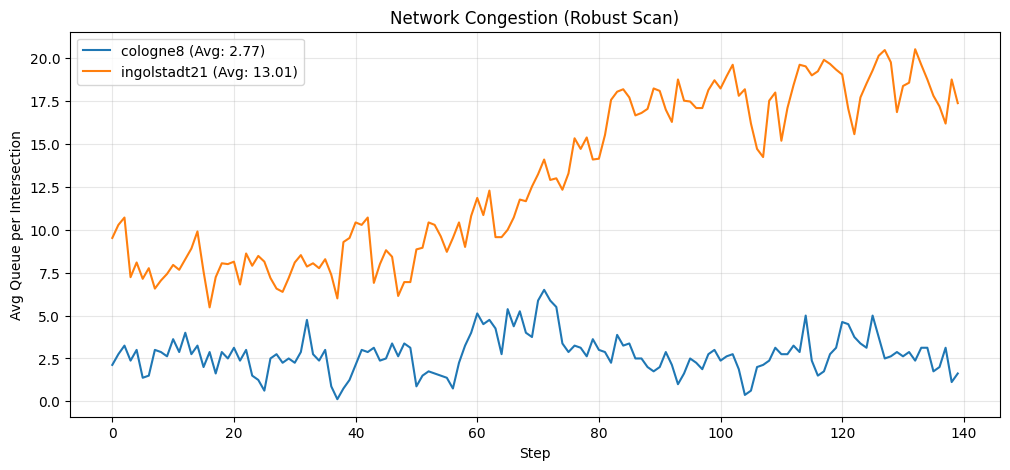

,Avg Queue (veh/junction),Avg Delay (s/junction),Est. Delay (s/veh)
cologne8,2.770536,53.911607,73.277913
ingolstadt21,13.005102,2165.158503,654.691556


In [21]:
# --- STEP 5: DEFINE TESTING ENVIRONMENTS (Real Cities) ---
# These are the "Target Domains" for transfer learning
test_environments = {
    'cologne8': SUMOTrafficEnvironment(f'{base_path}/cologne8/cologne8.sumocfg'),
    'ingolstadt21': SUMOTrafficEnvironment(f'{base_path}/ingolstadt21/ingolstadt21.sumocfg'),
}

# --- STEP 6: RUN EVALUATION ---
# We use the 'trainer' we just trained, but run it on 'test_environments'
print("\n📊 Starting Evaluation on Unseen Scenarios...")

# Using the robust evaluation function from before
eval_results = evaluate_model_robust(trainer, test_environments, num_steps=1000)

# --- PLOT & DISPLAY ---
plot_results(eval_results)

df_results = pd.DataFrame({
    k: {m: v for m, v in d.items() if m != 'history'}
    for k, d in eval_results.items()
}).T
display(df_results)